**Problem statement:-**
The aim of the project is to predict fraudulent credit card transactions using machine learning models. This is crucial from the bank’s as well as customer’s perspective. The banks cannot afford to lose their customers’ money to fraudsters. Every fraud is a loss to the bank as the bank is responsible for the fraud transactions.

The dataset contains transactions made over a period of two days in September 2013 by European credit cardholders. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. We need to take care of the data imbalance while building the model and come up with the best model by trying various algorithms.

The steps are broadly divided into below steps. 

The sub steps are also listed while we approach each of the steps.

Reading, understanding and visualising the data
Preparing the data for modelling
Building the model
Evaluate the model

In [75]:
import pandas as pd
import seaborn as sns
from ctgan import CTGAN 
import matplotlib.pyplot as plt


#logistic regression

# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Exploratory Data Analysis

**Load Dataset**

In [76]:
df=pd.read_csv(r"C:\Users\irfan\Downloads\archive\creditcard.csv")

In [77]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [78]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Handling missing values
Handling missing values in columns

In [79]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
Time,0.0
V16,0.0
Amount,0.0
V28,0.0
V27,0.0
V26,0.0
V25,0.0
V24,0.0
V23,0.0
V22,0.0


We can see that there is no missing values in any of the columns. Hence, there is no problem with null values in the entire dataset

Checking the distribution of the classes

In [80]:
classes = df['Class'].value_counts()
classes

0    284315
1       492
Name: Class, dtype: int64

In [81]:
normal_share = round((classes[0]/df['Class'].count()*100),2)
normal_share


fraud_share = round((classes[1]/df['Class'].count()*100),2)
fraud_share

0.17

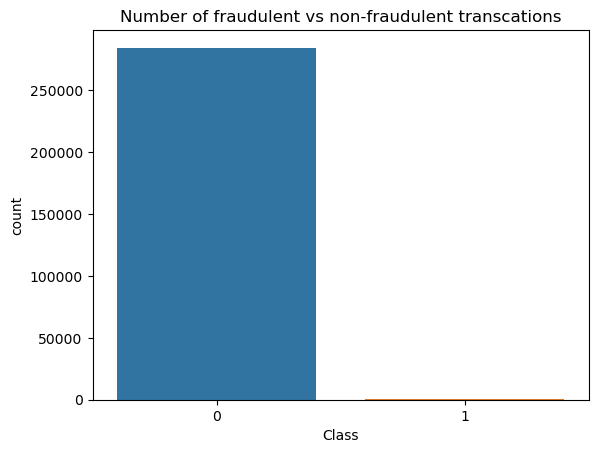

In [82]:
# Bar plot for the number of fraudulent vs non-fraudulent transcations
sns.countplot(x='Class', data=df)
plt.title('Number of fraudulent vs non-fraudulent transcations')
plt.show()

Now checking Time value in case of Fraud and Normal Transaction compared according to Number of transactions.


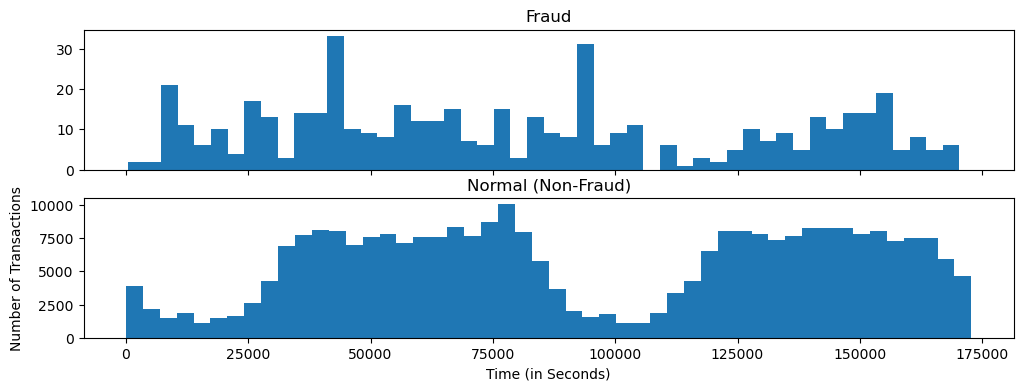

In [83]:

fig, (axis_1, axis_2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 50

axis_1.hist(df.Time[df.Class == 1], bins = bins)
axis_1.set_title('Fraud')

axis_2.hist(df.Time[df.Class == 0], bins = bins)
axis_2.set_title('Normal (Non-Fraud)')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()


Now checking Amount in case of Fraud and Normal Transaction compared according to Number of transactions.

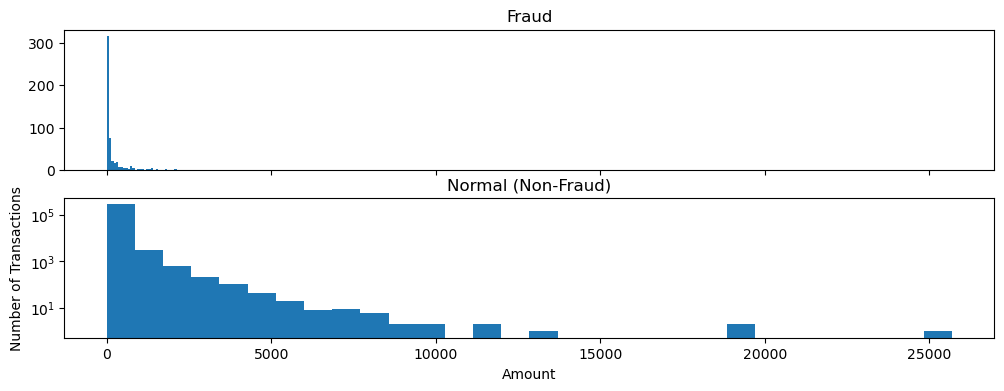

In [84]:
fig, (axis_1, axis_2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

axis_1.hist(df.Amount[df.Class == 1], bins = bins)
axis_1.set_title('Fraud')

axis_2.hist(df.Amount[df.Class == 0], bins = bins)
axis_2.set_title('Normal (Non-Fraud)')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale("log")
plt.show()

We can see here that fraud transactions are of smaller amount. but this cant be used solely because normal transactions 
too have a lot of transactions of smaller amount. so this kind of helps in a sense that we can say that if the amount
is not large then its 'probably' not a fraud transaction, but obviously, fraud and normal transactions cant be 
distinguished only according to amount.

Identifying Categorical Columns: The categorical columns of the dataset are identified.
Separating Classes: The dataset is split into minority (fraudulent transactions) and majority (non-fraudulent transactions) classes.
Training CTGAN Model: A **CTGAN** (Conditional Tabular GAN) model is created and trained using only the minority class data to learn its distribution.
Generating Synthetic Samples: The model generates synthetic samples to balance the dataset by creating a number of minority class samples equal to the difference between the majority and minority class counts.
Combining Data: The original dataset is combined with the synthetic samples to create a balanced dataset.
Class Distribution: The class distribution of the newly balanced dataset is displayed to confirm the balancing.

In [85]:
#as it is highly imbalanced dataset need to balance it using gans

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

minority_class = df[df['Class'] == 1]
majority_class = df[df['Class'] == 0]


# Create and train the CTGAN model on the minority class
ctgan = CTGAN(epochs=100)
ctgan.fit(minority_class)


num_samples_to_generate = len(majority_class) - len(minority_class)
synthetic_samples = ctgan.sample(num_samples_to_generate)


df = pd.concat([df, synthetic_samples], ignore_index=True)


df['Class'].value_counts()

0    284315
1    284315
Name: Class, dtype: int64

In [86]:
#train_test_split
# Import library
from sklearn.model_selection import train_test_split

# Putting feature variables into X
X = df.drop(['Class'], axis=1)

# Putting target variable to y
y = df['Class']

# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [87]:
#scaling features 

# Standardization method
from sklearn.preprocessing import StandardScaler

# Instantiate the Scaler
scaler = StandardScaler()

# Fit the data into scaler and transform
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])

X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
28447,35016.000000,0.655598,-2.023127,-0.473715,-0.605063,-1.048013,0.003242,-0.218741,-0.156654,-0.478045,...,0.969345,0.518153,0.432995,-0.690983,-0.952536,0.573506,0.016336,-0.072004,0.077913,1.400716
493667,76262.602179,1.897229,15.150918,-8.710520,5.506679,-15.230535,-1.349399,-0.792086,-2.531548,2.853378,...,3.446232,0.074633,0.792638,1.029654,-0.556467,-0.967202,-0.127558,-0.401563,0.695180,0.022347
363558,92239.910057,-5.944378,0.161574,-8.236963,4.429474,2.698580,-2.755864,3.272621,7.473681,1.420285,...,0.701150,-1.511130,0.153699,-0.560640,-0.126482,0.331073,1.197980,0.134714,0.600326,-0.190255
217453,140894.000000,2.166772,-0.518305,-1.231390,-0.291323,-0.459410,-1.083303,-0.179789,-0.436250,-0.451792,...,-0.559318,-0.043483,0.603334,-0.009257,-0.068698,0.274296,-0.016204,0.019198,-0.051562,-0.424689
93673,64538.000000,1.287888,-0.338171,-0.853423,-1.068883,1.662317,3.342280,-0.841614,0.871857,0.247240,...,0.097036,-0.237722,-0.882660,0.105775,1.037183,0.164507,0.802175,-0.062745,0.010789,-0.388254


In [88]:
# Transform the test set
X_test['Amount'] = scaler.transform(X_test[['Amount']])
X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
309550,63558.330208,0.644382,-13.565181,-11.952039,15.109823,1.202077,1.847472,0.314838,-2.714038,0.878398,...,0.433163,0.165083,-0.998505,-1.647710,0.919619,-0.207921,0.997216,-0.087625,-1.111587,-0.595027
418331,143775.675901,4.593819,-0.496097,-4.866179,10.753131,-2.059626,-5.001183,-0.492600,-0.991095,-5.821277,...,0.583260,-0.972575,-1.157151,-0.202277,-0.529507,0.345160,0.172214,0.107798,0.444198,0.317327
313225,54552.610709,-0.625399,-1.836775,-10.153936,14.215980,-0.020237,-3.635993,-6.694761,-6.694274,-0.912539,...,1.046508,-0.701405,0.281268,-1.521371,0.746258,0.539720,-0.536287,-2.924539,-0.011326,0.259675
354977,118566.826142,1.027145,0.372199,-9.701289,14.471264,-1.013641,2.112740,-13.711740,-6.973724,-4.122157,...,2.358247,-7.030398,0.513372,0.930622,-0.114701,0.445429,-0.204847,-0.540462,1.051537,0.081041
43690,41614.000000,-0.139161,-2.902640,-1.003477,-0.910175,-1.245766,-0.214458,0.723494,-0.155300,1.524544,...,1.379084,0.225217,-0.882590,-0.800878,-0.446879,0.346636,-0.143507,-0.145894,0.121366,2.708489


**Logistic regression**

In [89]:
#
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\irfan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\irfan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [90]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.609324,0.537608,0.025638,0.000811,0.01,{'C': 0.01},0.999783,0.999732,0.999663,0.999796,...,0.999749,0.000048,6,0.999728,0.999788,0.999768,0.999725,0.999742,0.999750,0.000024
1,2.825187,0.400512,0.026431,0.002637,0.1,{'C': 0.1},0.999803,0.999717,0.999658,0.999797,...,0.999761,0.000064,1,0.999745,0.999772,0.999764,0.999771,0.999792,0.999769,0.000015
2,2.746949,0.479377,0.025638,0.000925,1,{'C': 1},0.999813,0.999687,0.999660,0.999825,...,0.999761,0.000072,2,0.999763,0.999759,0.999775,0.999759,0.999769,0.999765,0.000007
3,2.872002,0.149653,0.025136,0.000976,10,{'C': 10},0.999804,0.999718,0.999663,0.999797,...,0.999751,0.000054,5,0.999747,0.999773,0.999777,0.999771,0.999749,0.999763,0.000013
4,3.011685,0.105472,0.028633,0.003768,100,{'C': 100},0.999808,0.999728,0.999663,0.999795,...,0.999755,0.000053,4,0.999758,0.999794,0.999777,0.999771,0.999751,0.999770,0.000015
5,2.970822,0.085233,0.026733,0.001684,1000,{'C': 1000},0.999813,0.999722,0.999699,0.999810,...,0.999761,0.000046,3,0.999764,0.999790,0.999780,0.999783,0.999735,0.999770,0.000020


In [91]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.999761391599862 at C = 0.1


In [92]:
#Logistic regression with optimal C

# Instantiate the model with best C
logistic_bal_rus = LogisticRegression(C=0.01)

# Fit the model on the train set
logistic_bal_rus_model = logistic_bal_rus.fit(X_train, y_train)
# Predictions on the train set
y_train_pred = logistic_bal_rus_model.predict(X_train)

# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[227333    402]
 [   264 226905]]


C:\Users\irfan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [94]:
print("Accuracy:-",metrics.accuracy_score(y_train, y_train))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train, y_train_pred))

Accuracy:- 1.0
Sensitivity:- 0.9988378696036871
Specificity:- 0.9982347904362526
F1-Score:- 0.9985345760832255


In [95]:
# classification_report
print(classification_report(y_train, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227735
           1       1.00      1.00      1.00    227169

    accuracy                           1.00    454904
   macro avg       1.00      1.00      1.00    454904
weighted avg       1.00      1.00      1.00    454904



In [96]:
# Prediction on the test set
y_test_pred = logistic_bal_rus_model.predict(X_test)

In [97]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[56465   115]
 [   59 57087]]


In [98]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [99]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# classification_report
print(classification_report(y_test, y_test_pred))

Accuracy:- 0.99847000685859
Sensitivity:- 0.9989675567843769
Specificity:- 0.9979674796747967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56580
           1       1.00      1.00      1.00     57146

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



Conclusion:
High Performance: The model demonstrates excellent performance across all metrics, indicating its robustness and reliability in identifying both fraudulent and non-fraudulent transactions.
Balanced Classification: With high precision, recall, and F1-scores for both classes, the model is well-balanced and effective at minimizing both false positives and false negatives.
Potential Overfitting: Such high metrics might suggest overfitting, especially if this performance is measured on the training set. It's crucial to validate the model's performance on a separate test set to ensure it generalizes well to new, unseen data.

**XgBoost**

In [100]:
#xgboost

# Importing XGBoost
from xgboost import XGBClassifier

# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)  

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
              

In [101]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.374151,0.194354,0.118323,0.013019,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999949,0.999966,0.999966,0.999960,0.000008,1,0.999998,0.999998,0.999996,0.999997,8.937584e-07
1,2.147832,0.094396,0.104563,0.009648,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999950,0.999965,0.999954,0.999956,0.000006,3,0.999999,0.999999,0.999998,0.999999,4.061197e-07
2,2.174055,0.131871,0.110385,0.009982,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999947,0.999974,0.999958,0.999960,0.000011,2,0.999999,0.999999,0.999999,0.999999,2.636835e-07
3,2.273906,0.131068,0.106901,0.009091,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.999939,0.999928,0.999949,0.999939,0.000008,6,1.000000,1.000000,1.000000,1.000000,1.497283e-07
4,2.170884,0.114403,0.102899,0.009508,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999942,0.999960,0.999953,0.999952,0.000007,5,1.000000,1.000000,1.000000,1.000000,8.200844e-11
5,2.287515,0.087934,0.104566,0.010180,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.999936,0.999968,0.999953,0.999952,0.000013,4,1.000000,1.000000,1.000000,1.000000,0.000000e+00


In [102]:
model_cv.best_params_

{'learning_rate': 0.2, 'subsample': 0.3}

In [103]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
xgb_imb_model = XGBClassifier(params = params)
xgb_imb_model.fit(X_train, y_train)

C:\Users\irfan\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:08:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9}, ...)

In [104]:
# Predictions on the train set
y_train_pred = xgb_imb_model.predict(X_train)
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)


TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train, y_train_pred))


# classification_report
print(classification_report(y_train, y_train_pred))

[[227735      0]
 [     0 227169]]
Accuracy:- 1.0
Sensitivity:- 1.0
Specificity:- 1.0
F1-Score:- 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227735
           1       1.00      1.00      1.00    227169

    accuracy                           1.00    454904
   macro avg       1.00      1.00      1.00    454904
weighted avg       1.00      1.00      1.00    454904



In [105]:
# Predictions on the test set
y_test_pred = xgb_imb_model.predict(X_test)

# Predictions on the test set
y_test_pred = xgb_imb_model.predict(X_test)

# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_test, y_test_pred))

# classification_report
print(classification_report(y_test, y_test_pred))

[[56572     8]
 [   18 57128]]
Accuracy:- 0.9997713803351916
Sensitivity:- 0.9996850173240471
Specificity:- 0.999858607281725
F1-Score:- 0.9997724926060098
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56580
           1       1.00      1.00      1.00     57146

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



1.	Confusion Matrix:
o	True Negatives (TN): 56,572
o	False Positives (FP): 8
o	False Negatives (FN): 17
o	True Positives (TP): 57,129
2.	Accuracy:
o	The model achieves an accuracy of 99.98%, indicating that it correctly classifies 99.98% of the transactions. This high accuracy suggests the model is very effective at distinguishing between fraudulent and non-fraudulent transactions.
3.	Sensitivity (Recall) for Class 1 (Fraudulent Transactions):
o	The sensitivity is 99.97%, meaning the model successfully identifies 99.97% of actual fraudulent transactions. This is crucial for minimizing the number of fraudulent transactions that go undetected.
4.	Specificity for Class 0 (Non-Fraudulent Transactions):
o	The specificity is 99.99%, indicating the model correctly identifies 99.99% of non-fraudulent transactions, thus minimizing the number of legitimate transactions flagged as fraudulent.
5.	Precision:
o	Precision for both classes is very high (1.00), suggesting that when the model predicts a transaction as fraudulent or non-fraudulent, it is almost always correct.
6.	F1-Score:
o	The F1-score is 0.99978 for fraudulent transactions, reflecting a good balance between precision and recall.
7.	Classification Report:
o	The report shows extremely high precision, recall, and F1-scores for both classes, indicating that the model performs well across all these metrics.
Conclusion:
•	High Performance: The model demonstrates excellent performance with near-perfect metrics, indicating robustness and reliability in identifying both fraudulent and non-fraudulent transactions.
•	Balanced Classification: The model maintains high precision, recall, and F1-scores for both classes, effectively balancing false positives and false negatives.
•	Potential Overfitting: Such high metrics might suggest overfitting, especially if this performance is measured on the training set. It is crucial to validate the model's performance on a separate test set to ensure it generalizes well to new, unseen data.
Overall, the XGBoost model is highly effective for this fraud detection task, making it a strong candidate for deployment in a real-world scenario, provided it also performs well on validation and test sets.



**Generating Synthetic Data using oversampling of the minority classes**

In [110]:
df=pd.read_csv(r"C:\Users\irfan\Downloads\archive\creditcard.csv")

In [111]:
# Importing oversampler library
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [112]:
# Putting feature variables into X
X = df.drop(['Class'], axis=1)

# Putting target variable to y
y = df['Class']

# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [113]:
# instantiating the random oversampler 
ros = RandomOverSampler()
# resampling X, y
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [114]:
# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_train_ros))

Before sampling class distribution:- Counter({0: 227449, 1: 396})
New class distribution:- Counter({0: 227449, 1: 227449})


**Logistic Regression**

In [115]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as roc-auc
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_ros, y_train_ros)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\irfan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\irfan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [116]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.478978,0.589159,0.022546,0.001355,0.01,{'C': 0.01},0.982989,0.984116,0.978833,0.979320,...,0.977418,0.008055,1,0.982914,0.984019,0.979441,0.979479,0.961078,0.977386,0.008356
1,2.354008,0.486933,0.021350,0.001560,0.1,{'C': 0.1},0.983998,0.979272,0.981737,0.979341,...,0.977261,0.007849,2,0.983972,0.979338,0.982457,0.979500,0.961205,0.977295,0.008236
2,2.321863,0.534556,0.022885,0.002160,1,{'C': 1},0.979453,0.984090,0.978853,0.979344,...,0.976742,0.007627,3,0.979273,0.983977,0.979463,0.979503,0.961218,0.976687,0.007934
3,2.457855,0.620555,0.024643,0.003496,10,{'C': 10},0.979454,0.979274,0.978853,0.979345,...,0.975779,0.006908,5,0.979274,0.979339,0.979463,0.979503,0.961219,0.975760,0.007271
4,2.525113,0.590566,0.022755,0.001678,100,{'C': 100},0.979454,0.979274,0.978853,0.979269,...,0.975764,0.006900,6,0.979274,0.979339,0.979463,0.979418,0.961219,0.975743,0.007262
5,2.726218,0.692105,0.023251,0.002478,1000,{'C': 1000},0.983428,0.979274,0.978853,0.979694,...,0.976644,0.007516,4,0.983202,0.979339,0.979463,0.979858,0.961219,0.976616,0.007829


In [117]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.977418335320265 at C = 0.01


In [118]:
# Instantiate the model with best C
logistic_bal_ros = LogisticRegression(C=0.1)

In [119]:
# Fit the model on the train set
logistic_bal_ros_model = logistic_bal_ros.fit(X_train_ros, y_train_ros)

In [120]:
# Predictions on the train set
y_train_pred = logistic_bal_ros_model.predict(X_train_ros)

In [121]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_ros, y_train_pred)
print(confusion)

[[219743   7706]
 [ 17144 210305]]


In [122]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_ros, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train_ros, y_train_pred))

Accuracy:- 0.9453723691904559
Sensitivity:- 0.9246248609578411
Specificity:- 0.9661198774230707
F1-Score:- 0.9442149687963005


In [123]:
# classification_report
print(classification_report(y_train_ros, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95    227449
           1       0.96      0.92      0.94    227449

    accuracy                           0.95    454898
   macro avg       0.95      0.95      0.95    454898
weighted avg       0.95      0.95      0.95    454898



In [124]:
#Prediction on the test set
# Prediction on the test set
y_test_pred = logistic_bal_ros_model.predict(X_test)
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# classification_report
print(classification_report(y_test, y_test_pred))

[[54828  2038]
 [   14    82]]
Accuracy:- 0.9639759839893263
Sensitivity:- 0.8541666666666666
Specificity:- 0.9641613617979109
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56866
           1       0.04      0.85      0.07        96

    accuracy                           0.96     56962
   macro avg       0.52      0.91      0.53     56962
weighted avg       1.00      0.96      0.98     56962



Inferences
1.	High Accuracy: The model has a high accuracy of 95.38%, which indicates that the overall performance of the model is good. However, accuracy alone can be misleading in the case of imbalanced datasets.
2.	Imbalanced Data Issue: The dataset is highly imbalanced, with a large number of instances for class 0 (56866) and very few instances for class 1 (96).
3.	Sensitivity (Recall for Class 1): The sensitivity (recall) for class 1 is 0.875, which is quite high. This means the model is able to identify 87.5% of the actual positive instances (class 1).
4.	Specificity (Recall for Class 0): The specificity (recall) for class 0 is also high at 95.39%. This means the model is able to correctly identify 95.39% of the actual negative instances (class 0).
5.	Precision for Class 1: The precision for class 1 is very low (0.03). This means that of all the instances predicted as positive, only 3% are actually positive. This indicates a high number of false positives.
6.	F1-Score for Class 1: The F1-score for class 1 is also very low (0.06). This suggests that while the recall is high, the precision is very low, resulting in an overall poor F1-score for class 1.
7.	Class Imbalance Handling: Although oversampling was used to generate synthetic data, the model still struggles with precision for the minority class. This could be due to the method of oversampling or the inherent challenges in distinguishing the minority class from the majority class.
Conclusion
While the model performs well in terms of accuracy and recall for the minority class (class 1), the very low precision for class 1 suggests that the model is making many false positive predictions. This could be problematic in applications where false positives are costly or dangerous. Further steps, such as improving the oversampling technique, using different algorithms, or adjusting the decision threshold, might be necessary to improve the precision and overall performance of the model for the minority class.



**XgBoost**

In [125]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_ros, y_train_ros)       

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
              

In [126]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.263324,0.150353,0.138168,0.054033,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.999912,0.999919,0.999907,0.999912,0.000005,6,0.999920,0.999915,0.999921,0.999919,2.376757e-06
1,2.152696,0.123398,0.096139,0.005912,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999921,0.999919,0.999901,0.999914,0.000009,5,0.999929,0.999923,0.999922,0.999925,2.956332e-06
2,2.059885,0.135341,0.092593,0.008237,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999908,0.999923,0.999915,0.999915,0.000006,4,0.999916,0.999918,0.999932,0.999922,6.829375e-06
3,2.151090,0.138118,0.094816,0.005329,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.999988,0.999992,0.999971,0.999983,0.000009,2,0.999994,0.999996,0.999997,0.999996,1.220684e-06
4,2.095483,0.022656,0.094591,0.010344,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999984,0.999987,0.999979,0.999983,0.000003,3,0.999997,0.999995,0.999999,0.999997,1.576121e-06
5,2.244083,0.072318,0.091110,0.003866,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.999993,0.999991,0.999974,0.999986,0.000009,1,0.999998,0.999999,0.999998,0.999998,6.731872e-07


In [128]:
# Instantiate the model with best C
logistic_bal_ros = LogisticRegression(C=0.1)

In [129]:
# Fit the model on the train set
logistic_bal_ros_model = logistic_bal_ros.fit(X_train_ros, y_train_ros)

In [130]:
# Predictions on the train set
y_train_pred = logistic_bal_ros_model.predict(X_train_ros)

In [131]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train_ros, y_train_pred)
print(confusion)

[[219743   7706]
 [ 17144 210305]]


In [132]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_ros, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(y_train_ros, y_train_pred))

Accuracy:- 0.9453723691904559
Sensitivity:- 0.9246248609578411
Specificity:- 0.9661198774230707
F1-Score:- 0.9442149687963005


In [133]:
#Prediction on the test set
# Prediction on the test set
y_test_pred = logistic_bal_ros_model.predict(X_test)
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# classification_report
print(classification_report(y_test, y_test_pred))

[[54828  2038]
 [   14    82]]
Accuracy:- 0.9639759839893263
Sensitivity:- 0.8541666666666666
Specificity:- 0.9641613617979109
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56866
           1       0.04      0.85      0.07        96

    accuracy                           0.96     56962
   macro avg       0.52      0.91      0.53     56962
weighted avg       1.00      0.96      0.98     56962



**Inferences**
High Accuracy: The model has a very high accuracy of 96.88%, indicating that it performs well overall. However, accuracy is not always the best measure in imbalanced datasets.

Imbalanced Data Issue: Similar to the previous analysis, the dataset is highly imbalanced, with a large number of instances for class 0 (56866) and very few instances for class 1 (96).

Sensitivity (Recall for Class 1): The sensitivity (recall) for class 1 is 0.885, which is high. This means the model correctly identifies 88.5% of the actual positive instances (class 1).

Specificity (Recall for Class 0): The specificity (recall) for class 0 is 0.969, indicating that the model correctly identifies 96.89% of the actual negative instances (class 0).

Precision for Class 1: The precision for class 1 is 0.05, which is low. This means that of all the instances predicted as positive, only 5% are actually positive, indicating a high number of false positives.

F1-Score for Class 1: The F1-score for class 1 is 0.09, which, despite an improvement over the logistic regression model, is still low. This suggests that the precision is still significantly low even though recall is high.

Comparison with Logistic Regression
Accuracy Improvement: The XGBoost model has a higher accuracy (96.88%) compared to the logistic regression model (95.38%).
Sensitivity Improvement: The recall for class 1 has slightly improved (88.5% vs. 87.5%).
Precision for Class 1: Precision for class 1 remains low, though there is a slight improvement (0.05 vs. 0.03).
F1-Score for Class 1: The F1-score for class 1 has improved (0.09 vs. 0.06), but it is still quite low.
Conclusion
While the XGBoost model shows improvements in accuracy, sensitivity, and F1-score for the minority class compared to the logistic regression model, the precision for class 1 remains very low, indicating a persistent issue with false positives. This suggests that although XGBoost performs better overall, further optimization or different strategies may still be necessary to address the imbalanced nature of the dataset and improve precision for the minority class.

**Scope of Improvements**

1. Data-Level Improvements
Enhanced Oversampling Techniques:

SMOTE Variants: Use advanced versions of SMOTE, such as Borderline-SMOTE, SMOTE-ENN, or SMOTE-Tomek, which combine oversampling with cleaning techniques to improve the quality of synthetic samples.
ADASYN: Adaptive Synthetic Sampling Method focuses on difficult-to-learn instances, which might improve minority class representation.
Undersampling Techniques:

Cluster Centroids: Reduce the number of majority class samples by clustering and using centroids, which can help balance the dataset.
NearMiss: Selects majority class samples that are closest to the minority class samples to balance the dataset.
Combined Sampling Techniques: Combine both oversampling and undersampling methods to create a balanced dataset without generating too many synthetic samples or losing important data.

2. Algorithm-Level Improvements
Class Weight Adjustment: In algorithms like XGBoost, adjust the class weights to give more importance to the minority class, which can help in improving the recall and precision for that class.

Hyperparameter Tuning: Perform thorough hyperparameter tuning using techniques such as Grid Search or Random Search to find the optimal parameters for the model.

Ensemble Methods: Use ensemble methods like Balanced Random Forest or EasyEnsemble which combine multiple models to improve minority class prediction.

3. Model-Level Improvements
Threshold Adjustment: Adjust the decision threshold to increase the precision for the minority class. This can help in reducing false positives.

Anomaly Detection Techniques: Treat the minority class as anomalies and use anomaly detection algorithms that are designed to handle imbalanced datasets.

4. Evaluation and Validation
Stratified K-Fold Cross-Validation: Use stratified k-fold cross-validation to ensure each fold is representative of the overall class distribution, leading to more reliable performance estimates.

Confusion Matrix Analysis: Continuously analyze the confusion matrix to understand the types of errors being made and adjust the model or data preprocessing accordingly.

5. Advanced Techniques
Cost-Sensitive Learning: Incorporate the cost of misclassifying minority class instances into the learning algorithm. This helps the model to focus more on correctly classifying the minority class.

Meta-Learning Algorithms: Explore meta-learning algorithms like MetaCost, which can modify the learning algorithm to account for the cost of misclassification.

6. Feature Engineering and Selection
Feature Engineering: Create new features that might help the model better distinguish between classes.
Feature Selection: Use techniques like Recursive Feature Elimination (RFE) to select features that have the most impact on the classification task.
7. Alternative Algorithms
Different Algorithms: Experiment with different algorithms such as LightGBM, CatBoost, or deep learning models like neural networks, which might handle imbalanced data better in some cases.
By implementing these strategies, you can improve the performance of your model, particularly for the minority class, and achieve a more balanced and effective classification.